# imports

In [1]:
import scanpy as sc
import SpaGCN as spg
import cv2
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2
from sklearn.metrics import *

In [18]:
sc.set_figure_params(vector_friendly=False,format='pdf',transparent=True,dpi=200)

# sns.set_style('white')
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 2}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 2})

import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# cls_cmp = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# not use HE

## load raw data

In [2]:

data_name = 'MIBI'
data_root = '/PUBDT/st/mibi/scmep/h5ad'
adata = sc.read_h5ad(f'{data_root}/{data_name}.h5ad')


In [3]:
adata_all = adata.copy()

In [4]:
adata = adata_all[adata_all.obs['point']=='16']

In [5]:
adata

View of AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden'
    uns: 'Cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'point_colors', 'umap'
    obsm: 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [6]:

adata.obs["x_pixel"]=adata.obsm['spatial'][:,1]
adata.obs["y_pixel"]=adata.obsm['spatial'][:,0]

Trying to set attribute `.obs` of view, copying.


In [7]:

x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()



## get adj

In [8]:
#Calculate adjacent matrix
s=1
b=49
# adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
# np.savetxt(f'{data_root}/results/adj.csv', adj, delimiter=',')

Calculateing adj matrix using xy only...


## set hyperparameters

In [9]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 873.5018149014994]
Run 2: l [0.01, 500.005], p [0.0, 600.5111083984375]
Run 3: l [0.01, 250.0075], p [0.0, 265.9469299316406]
Run 4: l [0.01, 125.00874999999999], p [0.0, 86.47460174560547]
Run 5: l [0.01, 62.509375], p [0.0, 24.273160934448242]
Run 6: l [0.01, 31.2596875], p [0.0, 6.18585729598999]
Run 7: l [0.01, 15.63484375], p [0.0, 1.2911121845245361]
Run 8: l [7.822421875, 15.63484375], p [0.10838079452514648, 1.2911121845245361]
Run 9: l [7.822421875, 11.728632812499999], p [0.10838079452514648, 0.560035228729248]
Run 10: l [9.77552734375, 11.728632812499999], p [0.29201316833496094, 0.560035228729248]
Run 11: l [10.752080078125, 11.728632812499999], p [0.41654956340789795, 0.560035228729248]
Run 12: l [11.2403564453125, 11.728632812499999], p [0.4860517978668213, 0.560035228729248]
Run 13: l [11.2403564453125, 11.48449462890625], p [0.4860517978668213, 0.5224981307983398]
recommended l =  11.362425537109374


In [10]:
#If the number of clusters known, we can use the spg.search_res() fnction to search for suitable resolution(optional)
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=2
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  8
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  7
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  7
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  5
Res changed to 0.4
Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Res =  0.30000000000000004 Num of clusters =  5
Res changed to 0.30000000000000004
Initializing cluster centers with louvain, resolution =  0.20000000000000004
Epoch  0
Epoch  10
delta_label  0.0009775171065493646 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 16
Res =  0.20000000000000004 Num of clusters =  3
Res changed to 0.2000000000000

In [12]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.



Initializing cluster centers with louvain, resolution =  0.10000000000000003
Epoch  0
Epoch  10
delta_label  0.0039100684261974585 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 16


In [14]:
adata

AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'x_pixel', 'y_pixel', 'pred'
    uns: 'Cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'point_colors', 'umap'
    obsm: 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

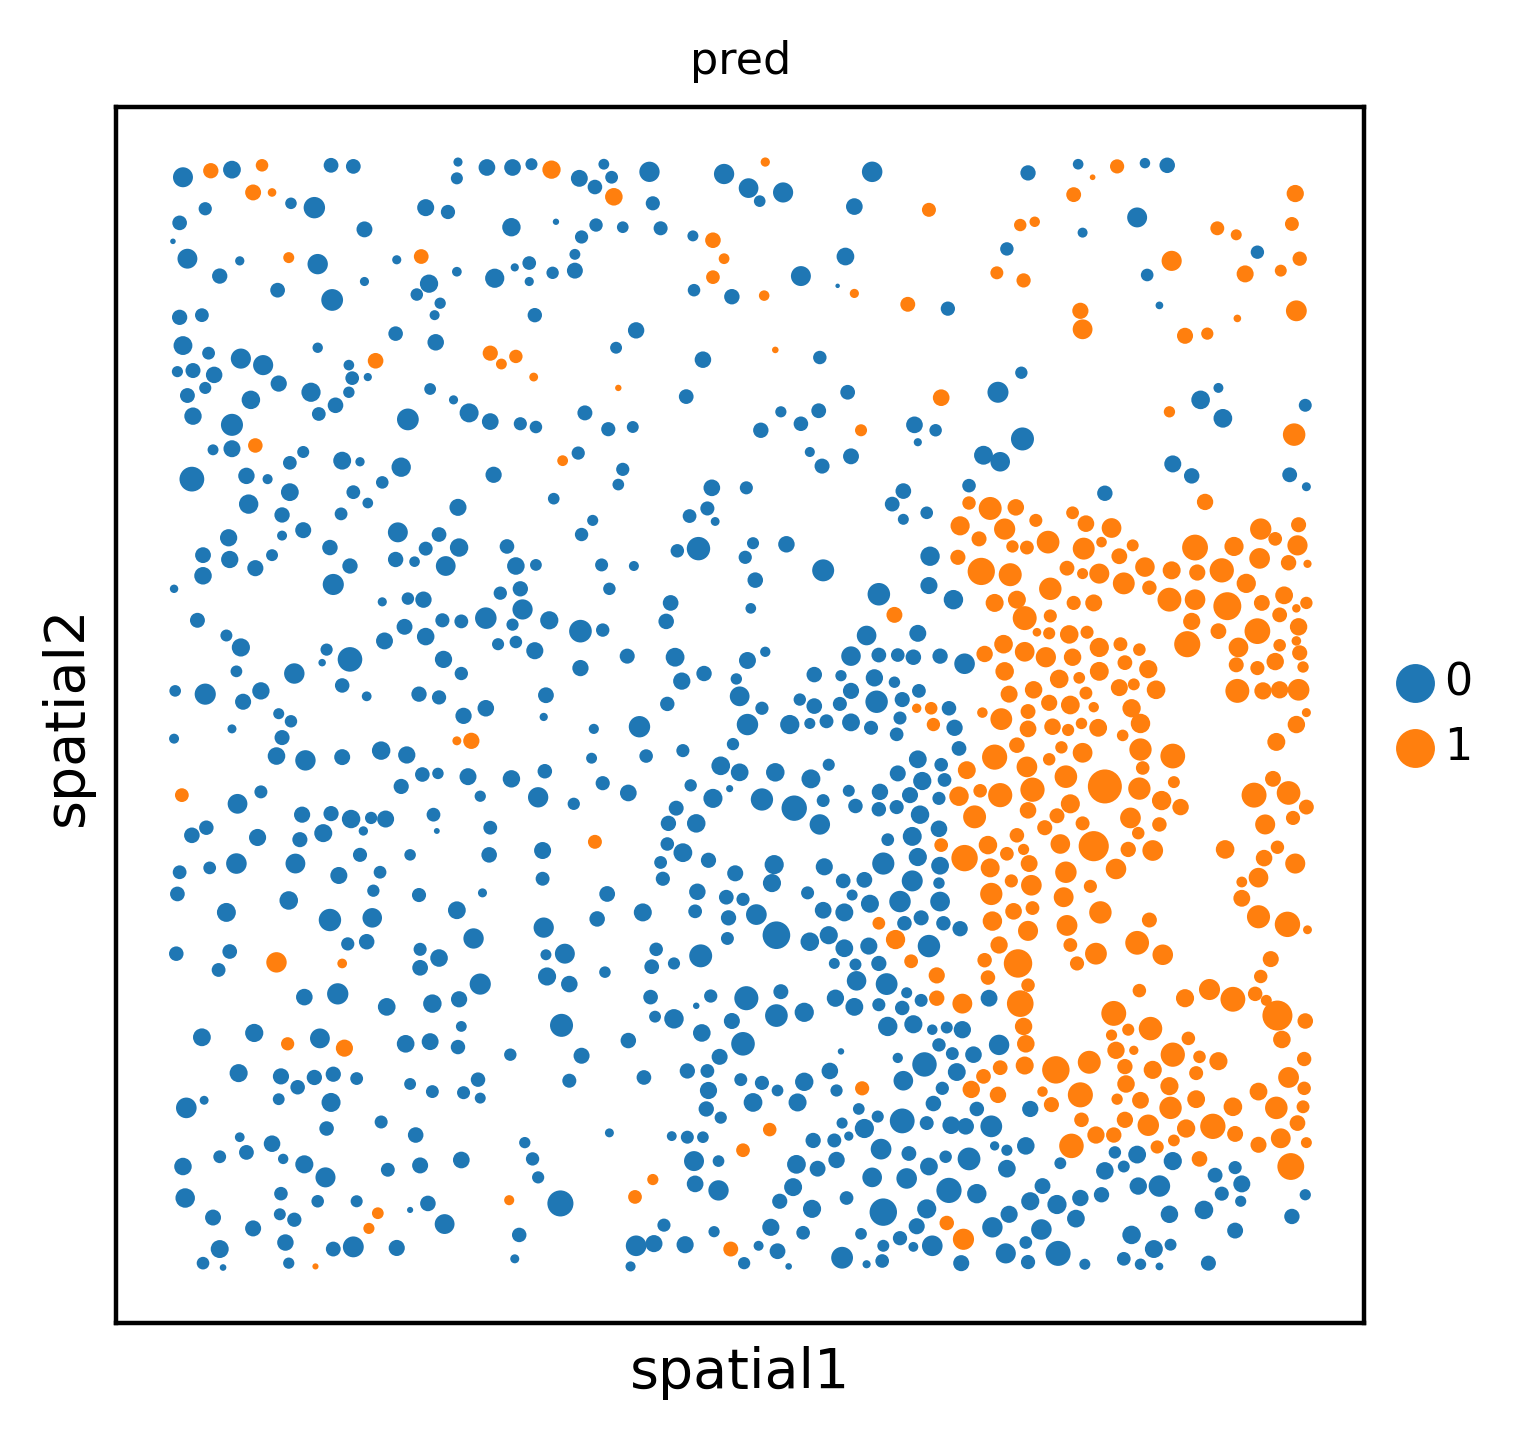

In [22]:
sc.pl.embedding(adata, basis='spatial', color=['pred'], size=adata.obs['cell_size']/10,ncols=2) 


In [21]:
adata.write_h5ad('p16_scagcn_20211201.h5ad')